# Test different metrics of surprise for framework paper

### set a measure of potential for inputs
 - for each road segment that is blocked calculate the potential as the capacity (lanes * speed)

In [1]:
from concurrent.futures import ThreadPoolExecutor
import sqlite3
import pickle
import pandas as pd
import json
import xml.etree.ElementTree as ET

In [2]:
def read_fleet_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()   
    print("Length of rows: ", len(rows)) 
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inIDS, output_90, output_100, odist]

        d = tmpDat
        scen = {}
            
        #try:
        #    root = d[2].getroot()
        #except:
        #    print('error')
        #    root = []
        #    continue
        scenID = d[0]
        #print(root.tag)
        #for child in root:    
        #    ### find the segment ID
        #    segmentID = child.find('ID').text
        #    speed = float(child.find('Freeflow_Speed').text)
        #    lanes = float(child.find('Number_of_Lanes').text)
        #    blocked = False
        #    if segmentID in link_ids:
        #        scen[segmentID] = speed
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

def read_ladris_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()    
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inXML, output_90, output_100, odist]

        d = tmpDat
        scen = {}

        scenID = d[0]
        #print(root.tag)
        #for child in d[2]:    
        #    ### find the segment ID
        #    segmentID = child['osmid']
        #    speed = float(child['speed_mph'])
        #    lanes = float(child['num_lanes'])
        #    blocked = child['is_blocked']
        #    if blocked == True:
        #        scen[segmentID] = 1
        #    #if segmentID in link_ids:
        #        #scen[segmentID] = blocked
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

In [3]:
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_roadBlocked_scenarios.db'
#dbFile = 'lhc_samples/fleet_scenarios_conv1.db'
dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv1.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv2.db'
comb_scenarios = {}


In [4]:
queries = [
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 4000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 6000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 1000 offset 8000',    
]

dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
with ThreadPoolExecutor(max_workers=6) as executor:
    ### if db file has fleet use function read_fleet_from_db else use read_ladris_from_db
    if 'fleet' in dbFile:
        for result in executor.map(read_fleet_from_db, queries):
            comb_scenarios.update(result)        
    else:
        for result in executor.map(read_ladris_from_db, queries):
            comb_scenarios.update(result)    

print(len(comb_scenarios))

Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  2000
2000


In [5]:
### join 3 sqlite database files
#dbFile1 = '/home/pfoytik/rtepm/EMA/lhc_samples/guid_blocked_ladris_scenarios.db'
#dbFile2 = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv1.db'
#dbFile3 = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv2.db'

#dbFile1 = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_roadBlocked_scenarios.db'
dbFile2 = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv1.db'
dbFile3 = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
dbFiles = [dbFile2, dbFile3]
comb_scenarios = {}
scenCount = 0
for dbFile in dbFiles:
    with ThreadPoolExecutor(max_workers=6) as executor:
        ### if db file has fleet use function read_fleet_from_db else use read_ladris_from_db
        if 'fleet' in dbFile:
            for result in executor.map(read_fleet_from_db, queries):
                comb_scenarios.update(result)        
        else:
            for result in executor.map(read_ladris_from_db, queries):
                for key, value in result.items():
                    if key in comb_scenarios:
                        new_key = scenCount + int(key)
                        scenCount += 1
                        comb_scenarios[new_key] = value
                    else:
                        comb_scenarios[key] = value 
print(len(comb_scenarios))

Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  292
Length of rows:  2000
Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  0
Length of rows:  2000
3896


# Get Ladris Roads
- Potential is measured as Lanes * Speed * Length

In [6]:
roadFile = '../lhc_samples/data/ladris/C27F9DE4CE6780696685FB4A4E31E242_orig'
with open(roadFile, 'r') as f:
    data = json.load(f)

ladris_latlong_dict = {}
ladris_potential_dict = {}
modified_dict = {}

for i in data:
    #print(i)
    ladris_latlong_dict[i['AC91D0B60F78BEFB85DE39CD9C3D2623']] = i['geometry']
    lanes = i['num_lanes']
    speed = i['speed_mph']
    ### convert speed to m/s
    speed = speed * 0.44704
    length = i['length_meters']
    ladris_potential_dict[i['AC91D0B60F78BEFB85DE39CD9C3D2623']] = lanes * speed * length

# Get Fleet Roads

In [7]:
### read segment id's from ../lhc_samples/data/fleet/segments.xml
tree = ET.parse('../lhc_samples/data/fleet/segments.xml')
root = tree.getroot()

fleet_segment_dict = {}
fleet_potential_dict = {}
for child in root:
    fleet_segment_dict[child.find('ID').text] = child.find('Link_ID').text
    lanes = int(child.find('Number_of_Lanes').text)
    speed = int(child.find('Freeflow_Speed').text)
    fleet_potential_dict[child.find('ID').text] = lanes * speed

### read ../lhcsamples/data/fleet/links.xml
tree = ET.parse('../lhc_samples/data/fleet/links.xml')
root = tree.getroot()

fleet_link_dict = {}
fleet_name_dict = {}
for child in root:
    fleet_link_dict[child.find('ID').text] = [child.find('ANode').text, child.find('BNode').text]    
    fleet_name_dict[child.find('ID').text] = child.find('Name').text

### read ../lhcsamples/data/fleet/nodes.xml and get lat long for BNode of each fleet_link_dict
tree = ET.parse('../lhc_samples/data/fleet/nodes.xml')
root = tree.getroot()

fleet_node_dict = {}
for child in root:
    fleet_node_dict[child.find('ID').text] = [child.find('Latitude').text, child.find('Longitude').text]

fleet_lat_long_dict = {}
### for each segment in fleet_segment_dict, get the link_id, from fleet_link_dict get the BNode, from fleet_node_dict get the lat long
for segment in fleet_segment_dict:
    link_id = fleet_segment_dict[segment]
    anode = fleet_link_dict[link_id][0]
    bnode = fleet_link_dict[link_id][1]
    lat_long = [fleet_node_dict[anode], fleet_node_dict[bnode]]
    fleet_lat_long_dict[int(segment)] = [[float(lat_long[0][1]), float(lat_long[0][0])],[float(lat_long[1][1]), float(lat_long[1][0])]]

In [8]:
df_results = pd.DataFrame([x[1] for x in comb_scenarios.values()])

dataDict = {}
for k in comb_scenarios.keys():
    for link in comb_scenarios[k][0]:        
        if link in dataDict.keys():
            pass
        else:
            #if link in link_ids:
            dataDict[link] = []   

for k in comb_scenarios.keys():
    for i in dataDict.keys():
        if i in comb_scenarios[k][0]:
            #if link in link_ids:
            dataDict[i].append(1)
        else:
            #if link in link_ids:
            dataDict[i].append(0) 

df = pd.DataFrame(dataDict)



In [9]:
if 'ladris' in dbFile:
    df_results['minutes'] = df_results[0] * 60
    df_results['hours'] = df_results[0]
else:
    ### create a new column for the df_results called minutes that is equal to df_results[0] / 60
    df_results['minutes'] = df_results[0] / 60
    ### create a new column for df_results called hours that is equal to df_results[0] / 3600
    df_results['hours'] = df_results[0] / 3600

df_results.describe()

,0,minutes,hours
count,3896.000000,3896.000000,3896.000000
mean,12577.284394,209.621407,3.493690
std,3661.927762,61.032129,1.017202
min,9600.000000,160.000000,2.666667
25%,9600.000000,160.000000,2.666667
50%,12900.000000,215.000000,3.583333
75%,13200.000000,220.000000,3.666667
max,30000.000000,500.000000,8.333333


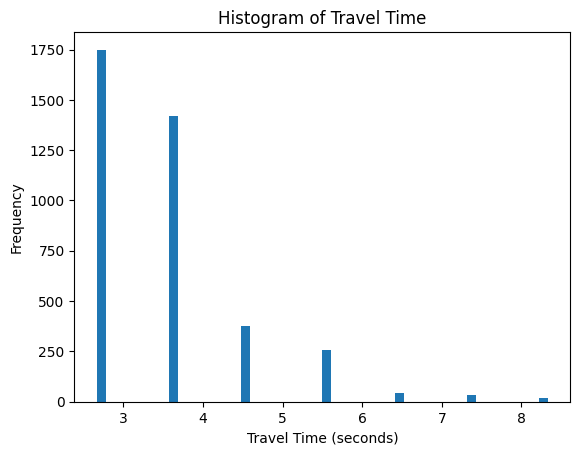

In [10]:
### Plot histogram of df_results
import matplotlib.pyplot as plt
plt.hist(df_results['hours'], bins=50)
plt.xlabel('Travel Time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Travel Time')
plt.show()

In [11]:
df_results['hours']

0       2.666667
1       4.583333
2       3.666667
3       3.666667
4       3.583333
          ...   
3891    3.583333
3892    2.666667
3893    3.666667
3894    3.666667
3895    3.583333
Name: hours, Length: 3896, dtype: float64

In [12]:

### get indexs of df_results for df_results['hours'] >= 6.5
idx = df_results[df_results['hours'] >= 4].index
### get indexs of df_results for df_results['hours'] < 6.5
idx2 = df_results[df_results['hours'] < 4].index

### describe df_results for the indexs of idx
df_results.loc[idx].describe()

,0,minutes,hours
count,727.000000,727.000000,727.000000
mean,18884.319120,314.738652,5.245644
std,3222.916659,53.715278,0.895255
min,16200.000000,270.000000,4.500000
25%,16500.000000,275.000000,4.583333
50%,16500.000000,275.000000,4.583333
75%,19800.000000,330.000000,5.500000
max,30000.000000,500.000000,8.333333


In [13]:
experiments = df
lowExperiments = experiments.loc[idx2]
highExperiments = experiments.loc[idx]
### Create outcomes as an array of df_results
outcomes = list(df_results['hours'].values)
lowOutcomes = list(df_results.loc[idx2]['hours'].values)
highOutcomes = list(df_results.loc[idx]['hours'].values)

In [14]:
### describe highOutcomes
pd.Series(highOutcomes).describe()

count    727.000000
mean       5.245644
std        0.895255
min        4.500000
25%        4.583333
50%        4.583333
75%        5.500000
max        8.333333
dtype: float64

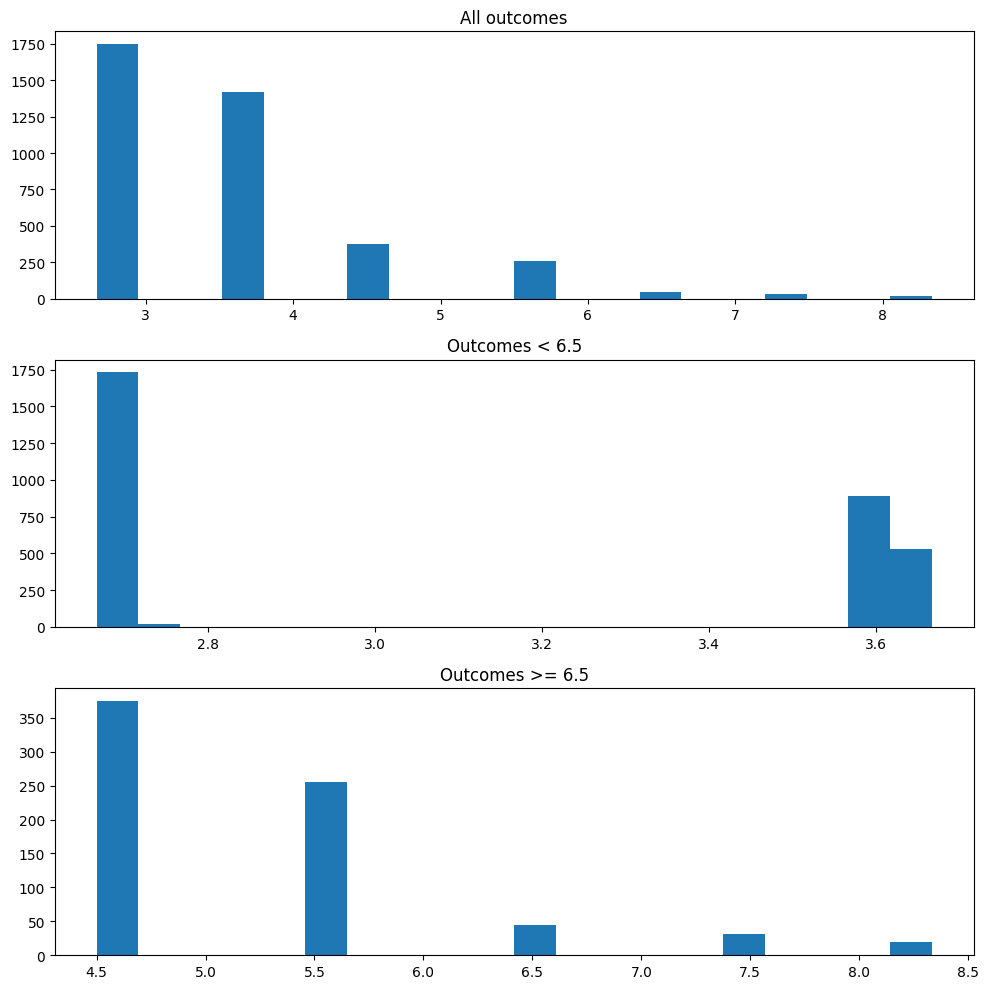

In [15]:
import matplotlib.pyplot as plt

### create three subplots of the outcomes
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].hist(outcomes, bins=20)
ax[0].set_title('All outcomes')
ax[1].hist(lowOutcomes, bins=20)
ax[1].set_title('Outcomes < 6.5')
ax[2].hist(highOutcomes, bins=20)
ax[2].set_title('Outcomes >= 6.5')
plt.tight_layout()
plt.show()


# The list of segments that are associated with High critical evacuation times and are low on potential
## Ladris Critical Segments
![image.png](images/ladris_critical_segments.png)
## Ladris Critical and Low Potential (CSI)
![image.png](images/lp80_hc4.png)
## Fleet Critical Segments
![image.png](images/fleet_critical_segments.png)
## Fleet Critical and Low Potential (CSI)
![image-2.png](images/fleet_CSI_segments.png)



# Custom surprising critical measure
$$
Z=λ_1 × EvacuationTime − λ_2 × ScenarioPotential
$$
- Evacuation time is time 90% of population reaches destination
- Scenario Potential is the total potential measure of closed segments for that scenario

In [16]:
### create a new dataframe from df where each column is multiplied by the corresponding value in ladris_potential_dict
ladris_potential_df = df.copy()
for i in ladris_potential_dict:
    if i in ladris_potential_df.columns:
        ladris_potential_df[i] = ladris_potential_df[i] * ladris_potential_dict[i]

ladris_potential_df.head()

,10091169783,949301691,10949397063,711440306,10116952815,711443713,10946271023,10105537445,10116970483,11156823230,...,703766232,105574067,949536370,10708503028,105576314,10091169790,949283531,711443269,91170034,10710783587
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,1,0,0,0,1,...,1,1,1,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,1,1,1,...,1,0,0,1,1,1,1,1,0,0
3,1,0,1,0,1,0,1,0,1,1,...,1,1,0,1,1,1,0,0,1,0
4,0,0,1,1,1,1,1,0,1,0,...,1,1,0,0,1,1,0,0,0,0


In [17]:
### add a new column to ladris_potential_df that is the sum of all the columns
ladris_potential_df['sum'] = ladris_potential_df.sum(axis=1)

### create a new column in ladris_potential_df called 'count' that is the count of columns that are greater than 0
ladris_potential_df['count'] = (ladris_potential_df > 0).sum(axis=1)

ladris_potential_df

,10091169783,949301691,10949397063,711440306,10116952815,711443713,10946271023,10105537445,10116970483,11156823230,...,949536370,10708503028,105576314,10091169790,949283531,711443269,91170034,10710783587,sum,count
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,18,19
1,1,1,1,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,22,23
2,1,0,0,1,0,0,0,1,1,1,...,0,1,1,1,1,1,0,0,17,18
3,1,0,1,0,1,0,1,0,1,1,...,0,1,1,1,0,0,1,0,17,18
4,0,0,1,1,1,1,1,0,1,0,...,0,0,1,1,0,0,0,0,16,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,5,6
3892,1,1,0,0,0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,7,8
3893,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,6,7
3894,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,5,6


In [18]:
lam1 = 0.5
lam2 = 1

### create x as a normalized measure of df_results['hours'] to be values between 0 and 1
normEvac = (df_results['hours'] - df_results['hours'].min()) / (df_results['hours'].max() - df_results['hours'].min())

### creaet normPot as a normalized measure of ladris_potential_df['sum'] to be values between 0 and 1
normPot = (ladris_potential_df['sum'] - ladris_potential_df['sum'].min()) / (ladris_potential_df['sum'].max() - ladris_potential_df['sum'].min())

df_results['z'] = lam1*normEvac - lam2*normPot + lam2

df_results.head()


,0,minutes,hours,z
0,9600,160.0,2.666667,0.333333
1,16500,275.0,4.583333,0.354303
2,13200,220.0,3.666667,0.458606
3,13200,220.0,3.666667,0.458606
4,12900,215.0,3.583333,0.488290


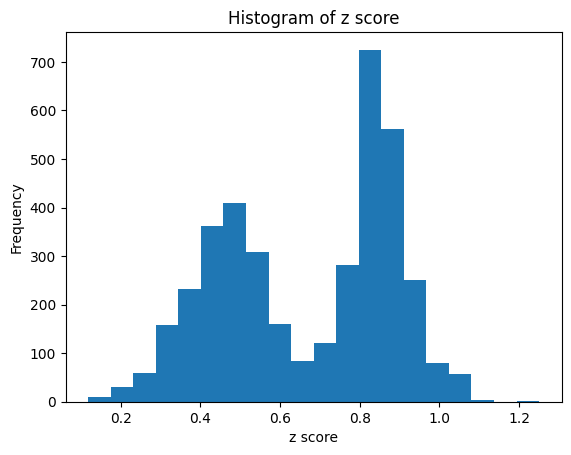

In [19]:
### Plot histogram of df_results['z']
plt.hist(df_results['z'], bins=20)
plt.xlabel('z score')
plt.ylabel('Frequency')
plt.title('Histogram of z score')
plt.show()

In [20]:
df_results['z'].describe()

count    3896.000000
mean        0.670699
std         0.217304
min         0.118464
25%         0.481481
50%         0.754902
75%         0.851852
max         1.250000
Name: z, dtype: float64

In [21]:
df.describe()

,10091169783,949301691,10949397063,711440306,10116952815,711443713,10946271023,10105537445,10116970483,11156823230,...,703766232,105574067,949536370,10708503028,105576314,10091169790,949283531,711443269,91170034,10710783587
count,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,...,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000,3896.000000
mean,0.500513,0.501283,0.245893,0.242556,0.243840,0.501797,0.242556,0.500000,0.500770,0.244353,...,0.246150,0.243840,0.498973,0.242813,0.244097,0.245380,0.244610,0.243070,0.243326,0.244610
std,0.500064,0.500063,0.430671,0.428684,0.429452,0.500061,0.428684,0.500064,0.500064,0.429758,...,0.430822,0.429452,0.500063,0.428838,0.429605,0.430367,0.429911,0.428992,0.429146,0.429911
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
import prim

# Perform Prim Analysis on df_results and df based on maximizing critical (hours)

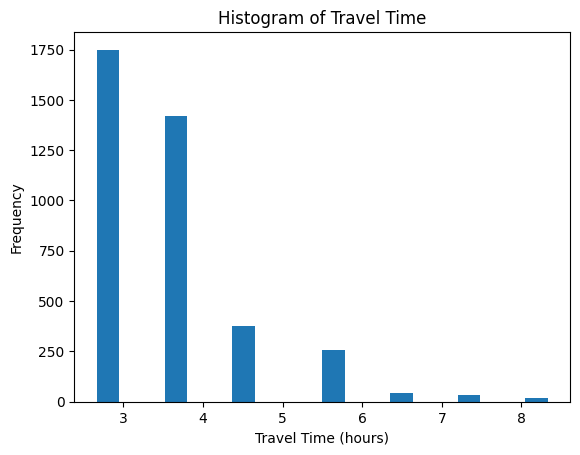

In [23]:
### plot histogram of df_results['hours']
plt.hist(df_results['hours'], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Travel Time')
plt.show()


In [24]:
### get the index values of df_results.loc[lp_evac_idx]['hours] that are greater than 4
#mask = df_results.loc[lp_evac_idx]['hours'] > 4
### get the index of df_results where df_results['hours'] > 4
critical_fleet_results_idx = df_results[df_results['hours'] > 4].index

### describe df_results.loc[critical_fleet_results_idx]
df_results.loc[critical_fleet_results_idx].describe()

,0,minutes,hours,z
count,727.000000,727.000000,727.000000,727.000000
mean,18884.319120,314.738652,5.245644,0.631755
std,3222.916659,53.715278,0.895255,0.220564
min,16200.000000,270.000000,4.500000,0.243192
25%,16500.000000,275.000000,4.583333,0.465414
50%,16500.000000,275.000000,4.583333,0.576525
75%,19800.000000,330.000000,5.500000,0.752451
max,30000.000000,500.000000,8.333333,1.250000


In [25]:
prim_alg = prim.Prim(df.loc[critical_fleet_results_idx], df_results.loc[critical_fleet_results_idx]['hours'], threshold=5, threshold_type='>')
crit_box = prim_alg.find_all()
print(len(crit_box))

9


In [26]:
crit_box[0].limits

/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


,min,max,qp values
10946271023,0.0,0.0,NaN
10116970483,1.0,1.0,NaN
91170204,0.0,0.0,NaN
10091170129,1.0,1.0,NaN
1175163236,0.0,0.0,NaN
10116945306,1.0,1.0,NaN
91170034,0.0,0.0,NaN


# Perform Prim Analysis on df_results and df based on maximizing z


In [27]:
df_results['z'].describe()

count    3896.000000
mean        0.670699
std         0.217304
min         0.118464
25%         0.481481
50%         0.754902
75%         0.851852
max         1.250000
Name: z, dtype: float64

In [28]:
### Get the index of rows in df_results['z'] that are greater than 0.1
idx = df_results[df_results['z'] > 0.75].index
### print the rows of df where the index is in idx
#df.loc[idx].describe()
df_results.loc[idx]['z'].describe()

count    1954.000000
mean        0.865341
std         0.063306
min         0.752451
25%         0.814815
50%         0.851852
75%         0.895697
max         1.250000
Name: z, dtype: float64

In [29]:
prim_alg = prim.Prim(df.loc[idx], df_results.loc[idx]['z'], threshold=0.89, threshold_type='>')
CSI_box = prim_alg.find_all()
print(len(CSI_box))

6


In [30]:
CSI_box[1].limits

/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


,min,max,qp values
10949397063,0.0,0.0,NaN
10116970483,1.0,1.0,NaN
11156823230,0.0,0.0,NaN
10091170129,1.0,1.0,NaN
10116945306,1.0,1.0,NaN
10091169790,0.0,0.0,NaN


# Generate KML for crit_box and CSI_box IDs


In [31]:
### get list of all index values for each crit_box
crit_ids = []
for i in range(len(crit_box)):
    print(list(crit_box[i].limits.index))
    ### add crit_box[i].limits.index to crit_ids but only if it is not already in crit_ids
    for j in list(crit_box[i].limits.index):
        if j not in crit_ids:
            crit_ids.append(j)

### print the number of unique index values in crit_ids
print('Number of unique index values in crit_ids: ', len(set(crit_ids)))

csi_ids = []
for i in range(len(CSI_box)):
    print(list(CSI_box[i].limits.index))
    ### add CSI_box[i].limits.index to csi_ids but only if it is not already in csi_ids
    for j in list(CSI_box[i].limits.index):
        if j not in csi_ids:
            csi_ids.append(j)
### print the number of unique index values in csi_ids
print('Number of unique index values in csi_ids: ', len(set(csi_ids)))


['10946271023', '10116970483', '91170204', '10091170129', '1175163236', '10116945306', '91170034']
['10116970483', '1173061709', '10091170129', '10112051514', '10116945306']
['10116970483', '1173061709', '10091170129', '10091169790']
['10116952815', '10116970483', '91169787', '10105575029', '10116945306', '10091170208', '703766232', '105574067']
['10116970483', '10091170129', '10116945306', '949536370']
['10116970483', '91170209', '10091170129']
['10105537445', '10091170208']
['10116945306']
[]
Number of unique index values in crit_ids:  19
['711440306', '949536370', '10708503028']
['10949397063', '10116970483', '11156823230', '10091170129', '10116945306', '10091169790']
['949301691', '10105537445', '10116970483']
['10091169783', '711443713', '91169787', '949283531']
['10091169783']
[]
Number of unique index values in csi_ids:  15


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


In [32]:
fleet_lat_long_dict[int(crit_ids[0])]

[[-121.0313, 39.2669], [-121.03304, 39.2667]]

In [33]:
import ast
from geopandas import GeoDataFrame
import geopandas as gpd
from shapely.geometry import LineString


In [34]:
#### update fleet_lat_long_dict to be a dictionary of linestrings
for i in fleet_lat_long_dict:
    fleet_lat_long_dict[i] = LineString([ast.literal_eval(str(fleet_lat_long_dict[i][0])), ast.literal_eval(str(fleet_lat_long_dict[i][1]))])


In [35]:
#all_gdf = GeoDataFrame(geometry=[fleet_lat_long_dict[i] for i in fleet_lat_long_dict])
all_gdf = GeoDataFrame(
    {"id": list(fleet_lat_long_dict.keys()), "geometry": list(fleet_lat_long_dict.values())}
)

crit_sub_gdf = GeoDataFrame(
    {"id": [int(i) for i in crit_ids], "geometry": [fleet_lat_long_dict[int(i)] for i in crit_ids]}
)

csi_sub_gdf = GeoDataFrame(
    {"id": [int(i) for i in csi_ids], "geometry": [fleet_lat_long_dict[int(i)] for i in csi_ids]}
)


In [36]:
### output geodataframe sub_gdf to kml file where id is the identity label and geometry is the lat long for position of the segment
crit_sub_gdf.to_file('fleet_crit_segments_052125.kml', driver='KML', index=False)
csi_sub_gdf.to_file('fleet_csi_segments_052125.kml', driver='KML', index=False)




/home/pfoytik/anaconda3/lib/python3.10/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
/home/pfoytik/anaconda3/lib/python3.10/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


# Compare evac time for scenarios of CRIT and scenarios of CSI

In [37]:
print(len(crit_box), len(CSI_box))


9 6


In [38]:
import prim as prim
import numpy as np


In [39]:
def getCriticalTimes(df, crit_box):
    criticalTimes = {}
    for c in range(len(crit_box)):
        ctime = []
        tempDict = {}

        ## the list of column names
        #list(crit_box[0].limits.index))

        ### the list of values
        #list(crit_box[0].limits['min'])

        ### create dictionary of list(crit_box[0].limits.index) and list(crit_box[0].limits['min'])
        for i in range(len(list(crit_box[c].limits.index))):
            tempDict[list(crit_box[c].limits.index)[i]] = list(crit_box[c].limits['min'])[i]

        if len(tempDict) > 2:
            ### convert tempDict values to integers
            for i in tempDict:
                if isinstance(tempDict[i], str):
                    tempDict[i] = int(tempDict[i])
                else:
                    tempDict[i] = int(tempDict[i])
            #print(tempDict.values())

            ### get the index of df[list(crit_box[1].limits.index)] where the values are equal to tempDict.values()
            cb1_idx = list(df[list(crit_box[c].limits.index)].index)

            ### for each row of df[list(crit_box[1].limits.index)].values.tolist() compare the list to tempDict.values()
            count = 0
            for i in df[list(crit_box[c].limits.index)].values.tolist():
                if i == list(tempDict.values()):
                    #print(cb1_idx[count], i)
                    ctime.append(df_results.loc[cb1_idx[count]]['hours'])
                count += 1
            criticalTimes[c] = ctime
            print(round(np.mean(ctime), 2), round(np.max(ctime), 2), round(np.min(ctime), 2), len(ctime))
    return criticalTimes

# Results for Fleet
### All Data
| Mean | Max  | Min  | Count |
|------|------|------|-------|
| 3.49 | 8.33 | 2.67 | 3896  |

### Critical
| Mean | Max  | Min  | Count |
|------|------|------|-------|
| 4.42 | 7.42 | 2.67 | 281   |
| 4.74 | 6.5  | 3.67 | 108   |
| 5.1  | 6.5  | 2.67 | 117   |
| 3.98 | 7.42 | 2.67 | 521   |
| 5.11 | 8.33 | 2.67 | 262   |
| 4.1  | 8.33 | 2.67 | 746   |

### CSI
| Mean | Max  | Min  | Count |
|------|------|------|-------|
| 3.37 | 6.5  | 2.67 | 1239  |
| 4.41 | 7.42 | 2.67 | 290   |
| 3.12 | 5.5  | 2.67 | 467   |
| 3.17 | 7.42 | 2.67 | 613   |


In [40]:
### get critical times for each crit_box
criticalTimes = getCriticalTimes(df, crit_box)
#print(criticalTimes)
print("<><><><><><><><><><><><><><><><><>")
csiTimes = getCriticalTimes(df, CSI_box)
print(len(criticalTimes), len(csiTimes))

/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scal

4.42 7.42 2.67 281
4.74 6.5 3.67 108
5.1 6.5 2.67 117
3.98 7.42 2.67 521
5.11 8.33 2.67 262
4.1 8.33 2.67 746
<><><><><><><><><><><><><><><><><>
3.37 6.5 2.67 1239
4.41 7.42 2.67 290
3.12 5.5 2.67 467
3.17 7.42 2.67 613
6 4


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scal

In [41]:
df_results['hours'].describe()

count    3896.000000
mean        3.493690
std         1.017202
min         2.666667
25%         2.666667
50%         3.583333
75%         3.666667
max         8.333333
Name: hours, dtype: float64

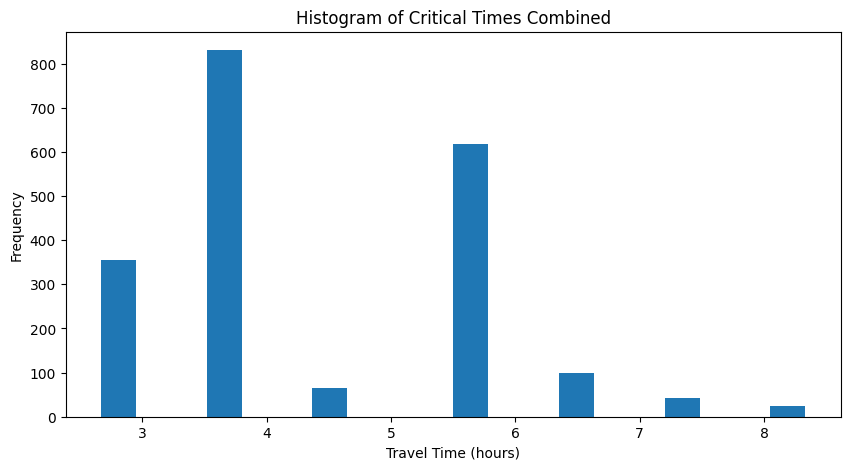

In [42]:
### create a histogram of the critical times combined
plt.figure(figsize=(10, 5))
plt.hist([item for sublist in criticalTimes.values() for item in sublist], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Critical Times Combined')
plt.show()

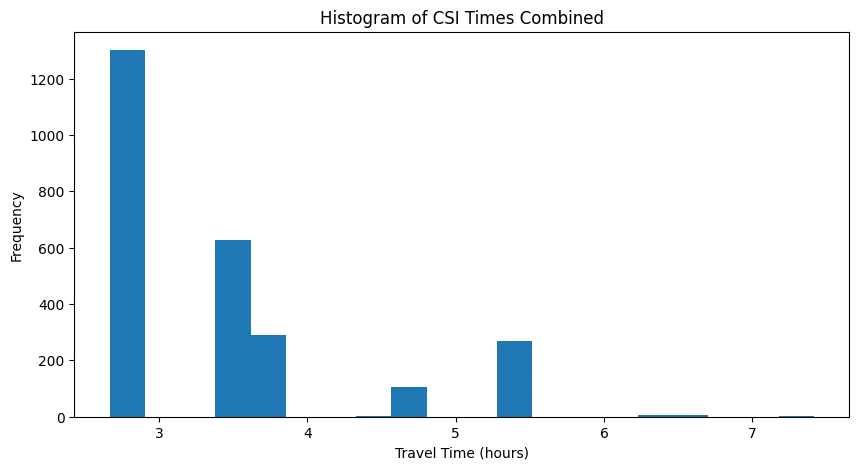

In [43]:
### create a histogram of csi times combined
plt.figure(figsize=(10, 5))
plt.hist([item for sublist in csiTimes.values() for item in sublist], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of CSI Times Combined')
plt.show()